In [105]:
%matplotlib inline
import numpy as np
import scipy as sp
from itertools import product
import json 
import csv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Cleaning up the Data a bit more

Now that we have successfully wrangled our data in a way that allowed us to develop indicators and standardizable quantities, we have to do a few more things to make it operable with the sklearn packages like used in HW3. We removed a transfer index 'Unnamed' and pull out two more columns. ListingStatus is the same for all (we only took completed listings) and only 2 entries of our dataset had ReserveMet as True. The NaNs otherwise would cause problems with standardization.

In [106]:
df=pd.read_csv("dftouse_textanalysis.csv")

In [107]:
#Remove columns that aren't relevant
del df['Unnamed: 0']
del df['Unnamed: 0.1']
del df['ReserveMet']
del df['ListingStatus']
df = df[pd.isnull(df.HitCount) == False]


In [108]:
dftouse = df.copy()
dftouse.head()

,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,enoughKeyWords
0,1,131642735687,1,10590,1,False,False,0,False,41,NaN,202.09,False,2,190,1,"South Salem, New York",204.59,NaN,1,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,4,False,False,True,2,False,False,NaN,0,0,5,5,168,False
1,1,262126933108,1,35004,1,False,False,0,False,4,NaN,260.00,False,3,32,1,"Moody, Alabama",265.00,NaN,1,0,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,4,False,False,True,0,False,False,NaN,0,0,3,32,120,False
2,1,252155964081,1,98104,1,False,False,0,False,3,NaN,152.50,False,2,168,1,"Seattle, Washington",155.00,168534287,1,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120,True
3,1,252163774777,1,98104,1,False,False,0,False,1,NaN,99.00,False,2,143,1,"Seattle, Washington",100.00,168553370,1,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,0,False,False,True,0,False,False,NaN,0,1,2,17,120,True
4,1,252171170160,1,98104,1,False,True,0,False,5,NaN,96.00,False,2,357,1,"Seattle, Washington",97.00,168534287,1,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120,True


## A quick look

Let's take a first glance at the comparison of some of our important variables. Two important important variables that tell us about a successful auction are the FinalPrice and what the sellingStatus of the item is, which is 0 for a sold item and 1 for an item that did not sell. We also look at:

        - RatingsPresent: whether or not they made their ratings visible
        - PositiveFeedbackPercent: if this is 100, people never complain about this seller
        - conditionId: if the item new or used, and to what extent is it used. New is 9, 0-2 is not fully functional

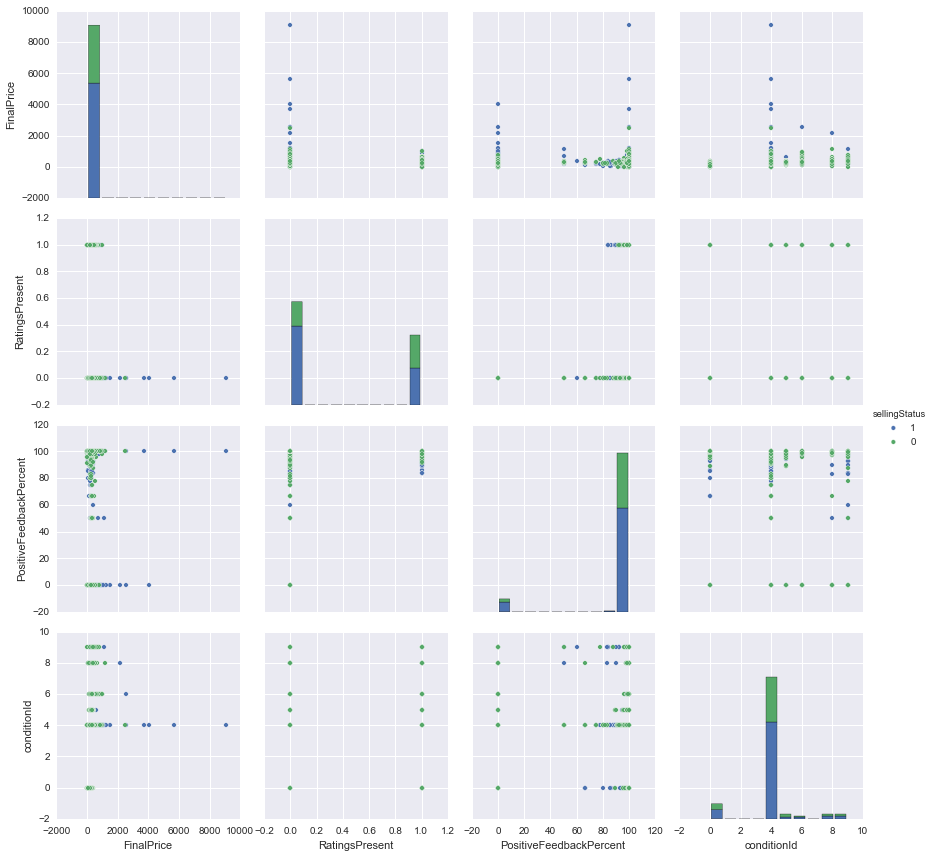

In [109]:
import seaborn as sns
sns.set()

sns.pairplot(df, hue='sellingStatus', vars=['FinalPrice','RatingsPresent','PositiveFeedbackPercent','conditionId'], size=3)

We see that very few people have a positive feedback percent in the range between 0 and 100, and that most of the ratings are either near 0% or near 100%. This tells us that very few ebay sellers are polarizing - either they are consistently bad or good, or some of those near 0% and 100% haven't sold many items so their small sample size naturally condones something near 0% or 100%. The most common condition of an item is conditionId 4, which, according to our dataframe_manipulation ipython notebook, indicates a conditionId of "Used". Everyone with a 0% positive feedback rating, irregardless of item condition, did not successfully sell their item. The vast majority of people also have positive feedback, which is good for worldly morality! Interestingly, while overall our dataframe is split ~65% sold 35% didn't sell, when people made their ratings present, a larger portion of them failed to sell. 

## Now we will do some Feature engineering

This is to figure out which variables actually make a distinction on item sellability. We separate our variables in similar manner to Homework 3. Certain parameters that are zero can be significant indicators of specific characteristics of an auction. For example, if the HitCount is zero, that means nobody really bothered to interact with the auction at all.

In [110]:
ZERO_IMPORTANT_VARIABLES = ['BidCount', 'HitCount', 'nPhotos', 'FeedbackScore', 'PositiveFeedbackPercent',
                           'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day']
STANDARDIZABLE = ZERO_IMPORTANT_VARIABLES + ['FinalPrice','auctionLength', 'HandlingTime', 'FeedbackScore', 
                  'PositiveFeedbackPercent', 'Quantity', 'nPaymentMethods', 'nShippingCountries', 'auctionLength']
INDICATORS = []

**We go ahead and make our list of indicators, making sure to not duplicate indicator names based on the list they are in.**

In [111]:
for v in df.columns:
    if v != 'sellingStatus':
        l=df[v].unique()
        if len(l) <= 10:
            if v not in STANDARDIZABLE:
                dftouse.rename(columns={v:'i_'+v}, inplace=True)
                INDICATORS.append('i_'+v)
            else:
                dftouse['i_'+v]=(dftouse[v] > 0.0)*1
                INDICATORS.append('i_'+v)
            print v, l

for v in ZERO_IMPORTANT_VARIABLES:
    dftouse['i_'+v]=(dftouse[v] > 0.0)*1
    INDICATORS.append('i_'+v)
    print v
    
#INDICATORS.remove('i_sellingStatus')
print INDICATORS


country [1 0]
paymentMethod [1 0]
topRatedListing [False True]
AutoPay [False True]
AvailableForPickupDropOff [0 1]
BestOfferEnabled [False True]
GlobalShipping [False True]
HandlingTime [ 2.  3.  1.  0.]
ListingType [1 0]
QuantityThreshold [  0.  10.]
SellerBusinessType [2 1 0]
NewUser [False True]
nPaymentMethods [1 2 4 3]
conditionId [4 0 9 8 6 5]
bestOfferEnabled [False True]
buyItNowAvailable [False True]
expeditedShipping [True False]
shippingType [ 2.  0.  1.  3.  4.  8.]
oneDayShippingAvailable [False True]
RatingsPresent [False True]
enoughKeyWords [False True]
BidCount
HitCount
nPhotos
FeedbackScore
PositiveFeedbackPercent
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
['i_country', 'i_paymentMethod', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'i_GlobalShipping', 'i_HandlingTime', 'i_ListingType', 'i_QuantityThreshold', 'i_SellerBusinessType', 'i_NewUser', 'i_nPaymentMethods', 'i_conditionId', 'i_bestOfferEnab

We divide our dataframe up into a training and a test set in order to run our regressions and SVMs on the data. Our goal here is to figure out what probability of selling maximizes our profit, so we look to get the best estimate of sellingStatus so that we can use it later on.

In [112]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [113]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [114]:
mask.shape, mask.sum()

((9267,), 6486)

Here we standardize our two masks (train and test) separately to make them distinct so that we have an essentially independent dataset to test our predictor on. Doing so allows us to better understand if we are doing a good job with predicting *any* set of iPhone 5s 32gb auction data and not just predicting the data we already had really well.

In [115]:
from sklearn import preprocessing

#we make our training and testing sets w/ standarized
scaler = preprocessing.StandardScaler().fit(dftouse[mask][STANDARDIZABLE])
dftouse.loc[mask, STANDARDIZABLE] = scaler.transform(dftouse[mask][STANDARDIZABLE]) 
dftouse.loc[~mask,STANDARDIZABLE] = scaler.transform(dftouse[~mask][STANDARDIZABLE])


dftouse[mask].head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_enoughKeyWords,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
1,1,262126933108,1,35004,1,False,False,0,False,-0.220782,NaN,0.016585,False,1.791518,-0.051732,1,"Moody, Alabama",265,NaN,-0.040077,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.202401,0.298235,1,False,-1.132265,-0.076645,-0.825346,4,False,False,True,0,False,False,NaN,-0.156227,-0.240002,-0.269829,-0.293142,-0.056611,False,1,1,1,1,1,1,1,0,0,1,1
2,1,252155964081,1,98104,1,False,False,0,False,-0.300653,NaN,-0.623542,False,0.422229,-0.034634,1,"Seattle, Washington",155,168534287,-0.040077,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221422,0.067556,1,False,-1.132265,-0.076645,-0.825346,4,False,False,False,1,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1
3,1,252163774777,1,98104,1,False,False,0,False,-0.460393,NaN,-0.942117,False,0.422229,-0.037777,1,"Seattle, Washington",100,168553370,-0.040077,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.221422,0.067556,1,False,0.506480,-0.076645,-0.825346,0,False,False,True,0,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1
4,1,252171170160,1,98104,1,False,True,0,False,-0.140912,NaN,-0.959981,False,0.422229,-0.010873,1,"Seattle, Washington",97,168534287,-0.040077,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221422,0.067556,1,False,-1.132265,-0.076645,-0.825346,4,False,False,False,1,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1
5,1,252171162991,1,98104,1,False,False,0,False,-0.300653,NaN,-1.043346,False,0.422229,-0.017411,1,"Seattle, Washington",83,168553370,-0.040077,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.221422,0.067556,1,False,0.506480,-0.076645,-0.825346,0,False,False,True,0,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1


In [116]:
lcols=list(dftouse.columns)
print lcols
lcols.remove(u'sellingStatus')
print len(lcols)

['i_country', 'itemId', 'i_paymentMethod', 'postalCode', 'sellingStatus', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'BidCount', 'BuyItNowPrice', 'FinalPrice', 'i_GlobalShipping', 'HandlingTime', 'HitCount', 'i_ListingType', 'Location', 'MinimumToBid', 'ProductID', 'Quantity', 'i_QuantityThreshold', 'ShipToLocations', 'Title', 'UserID', 'FeedbackScore', 'PositiveFeedbackPercent', 'i_SellerBusinessType', 'i_NewUser', 'nPhotos', 'nPaymentMethods', 'nShippingCountries', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType', 'i_oneDayShippingAvailable', 'i_RatingsPresent', 'AverageRating', 'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day', 'auctionLength', 'i_enoughKeyWords', 'i_HandlingTime', 'i_nPaymentMethods', 'i_BidCount', 'i_HitCount', 'i_nPhotos', 'i_FeedbackScore', 'i_PositiveFeedbackPercent', 'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day', '

In [117]:
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)


ccols.remove('itemId')
ccols.remove('postalCode')
#ccols.remove('sellingStatus')
ccols.remove('Location')
ccols.remove('ProductID')
ccols.remove('ShipToLocations')
ccols.remove('Title')
ccols.remove('UserID')
print len(ccols), len(INDICATORS)

18 30


In [118]:
dftouse.head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_enoughKeyWords,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,1,131642735687,1,10590,1,False,False,0,False,2.734417,NaN,-0.328250,False,0.422229,-0.031868,1,"South Salem, New York",204.59,NaN,-0.040077,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.221284,0.298235,2,False,-0.804516,-0.076645,-0.825346,4,False,False,True,2,False,False,NaN,-0.156227,-0.240002,-0.261852,-0.301881,0.055444,False,1,1,1,1,1,1,1,0,0,1,1
1,1,262126933108,1,35004,1,False,False,0,False,-0.220782,NaN,0.016585,False,1.791518,-0.051732,1,"Moody, Alabama",265.00,NaN,-0.040077,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.202401,0.298235,1,False,-1.132265,-0.076645,-0.825346,4,False,False,True,0,False,False,NaN,-0.156227,-0.240002,-0.269829,-0.293142,-0.056611,False,1,1,1,1,1,1,1,0,0,1,1
2,1,252155964081,1,98104,1,False,False,0,False,-0.300653,NaN,-0.623542,False,0.422229,-0.034634,1,"Seattle, Washington",155.00,168534287,-0.040077,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221422,0.067556,1,False,-1.132265,-0.076645,-0.825346,4,False,False,False,1,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1
3,1,252163774777,1,98104,1,False,False,0,False,-0.460393,NaN,-0.942117,False,0.422229,-0.037777,1,"Seattle, Washington",100.00,168553370,-0.040077,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.221422,0.067556,1,False,0.506480,-0.076645,-0.825346,0,False,False,True,0,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1
4,1,252171170160,1,98104,1,False,True,0,False,-0.140912,NaN,-0.959981,False,0.422229,-0.010873,1,"Seattle, Washington",97.00,168534287,-0.040077,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.221422,0.067556,1,False,-1.132265,-0.076645,-0.825346,4,False,False,False,1,False,False,NaN,-0.156227,-0.204123,-0.273817,-0.297997,-0.056611,True,1,1,1,1,1,1,1,0,1,1,1


Creating a set of **K**ernel **De**nsity Plots (KDE) allows us to look at the non-indicator data that has a wide range of values to see how they vary depending on sellability or not.

BidCount
BuyItNowPrice
FinalPrice
HandlingTime
HitCount
MinimumToBid
Quantity
FeedbackScore
PositiveFeedbackPercent
nPhotos
nPaymentMethods
nShippingCountries
AverageRating
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
auctionLength


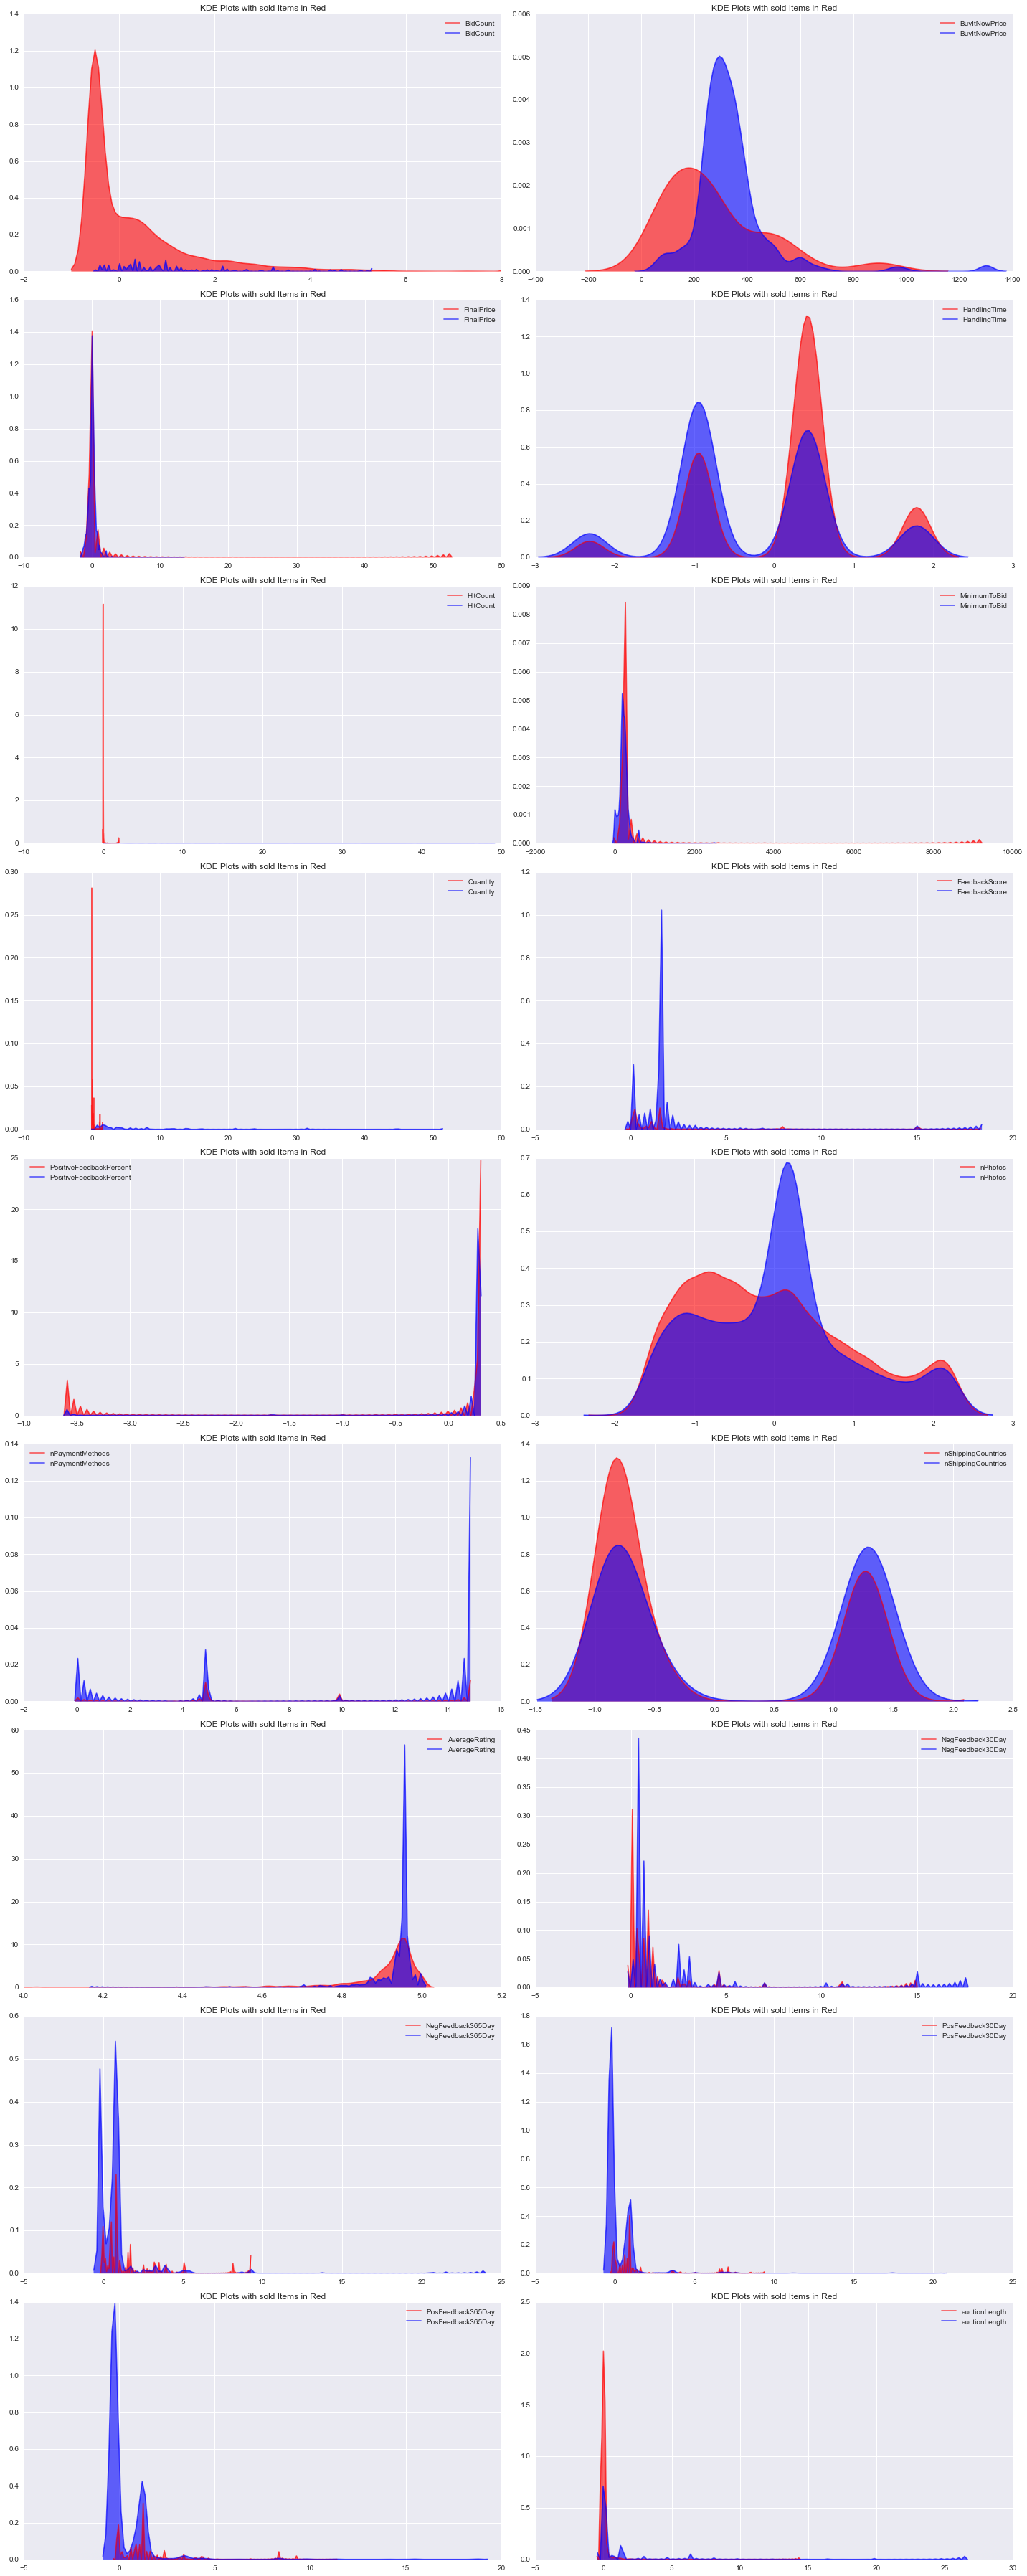

In [119]:
fig, axes = plt.subplots(nrows=9, ncols=2, sharex=False, sharey=False, figsize=(20, 50), 
                         tight_layout=True)
for ax, ccol in zip(axes.ravel(), ccols):
    
    #plot mean values per year based on response to mailing
    df_col = dftouse[ccol]
    print ccol
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 1], color='r', alpha=.6, ax=ax, shade=True, legend=True)
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 0], color='b', alpha=.6, ax=ax, shade=True)
    ax.set_title("KDE Plots with sold Items in Red")

Next we do a similar binary plot of sold vs. not sold for our indicators. How each of these are defined is explained in the dataframe_manipulation notebook in the mapping section.

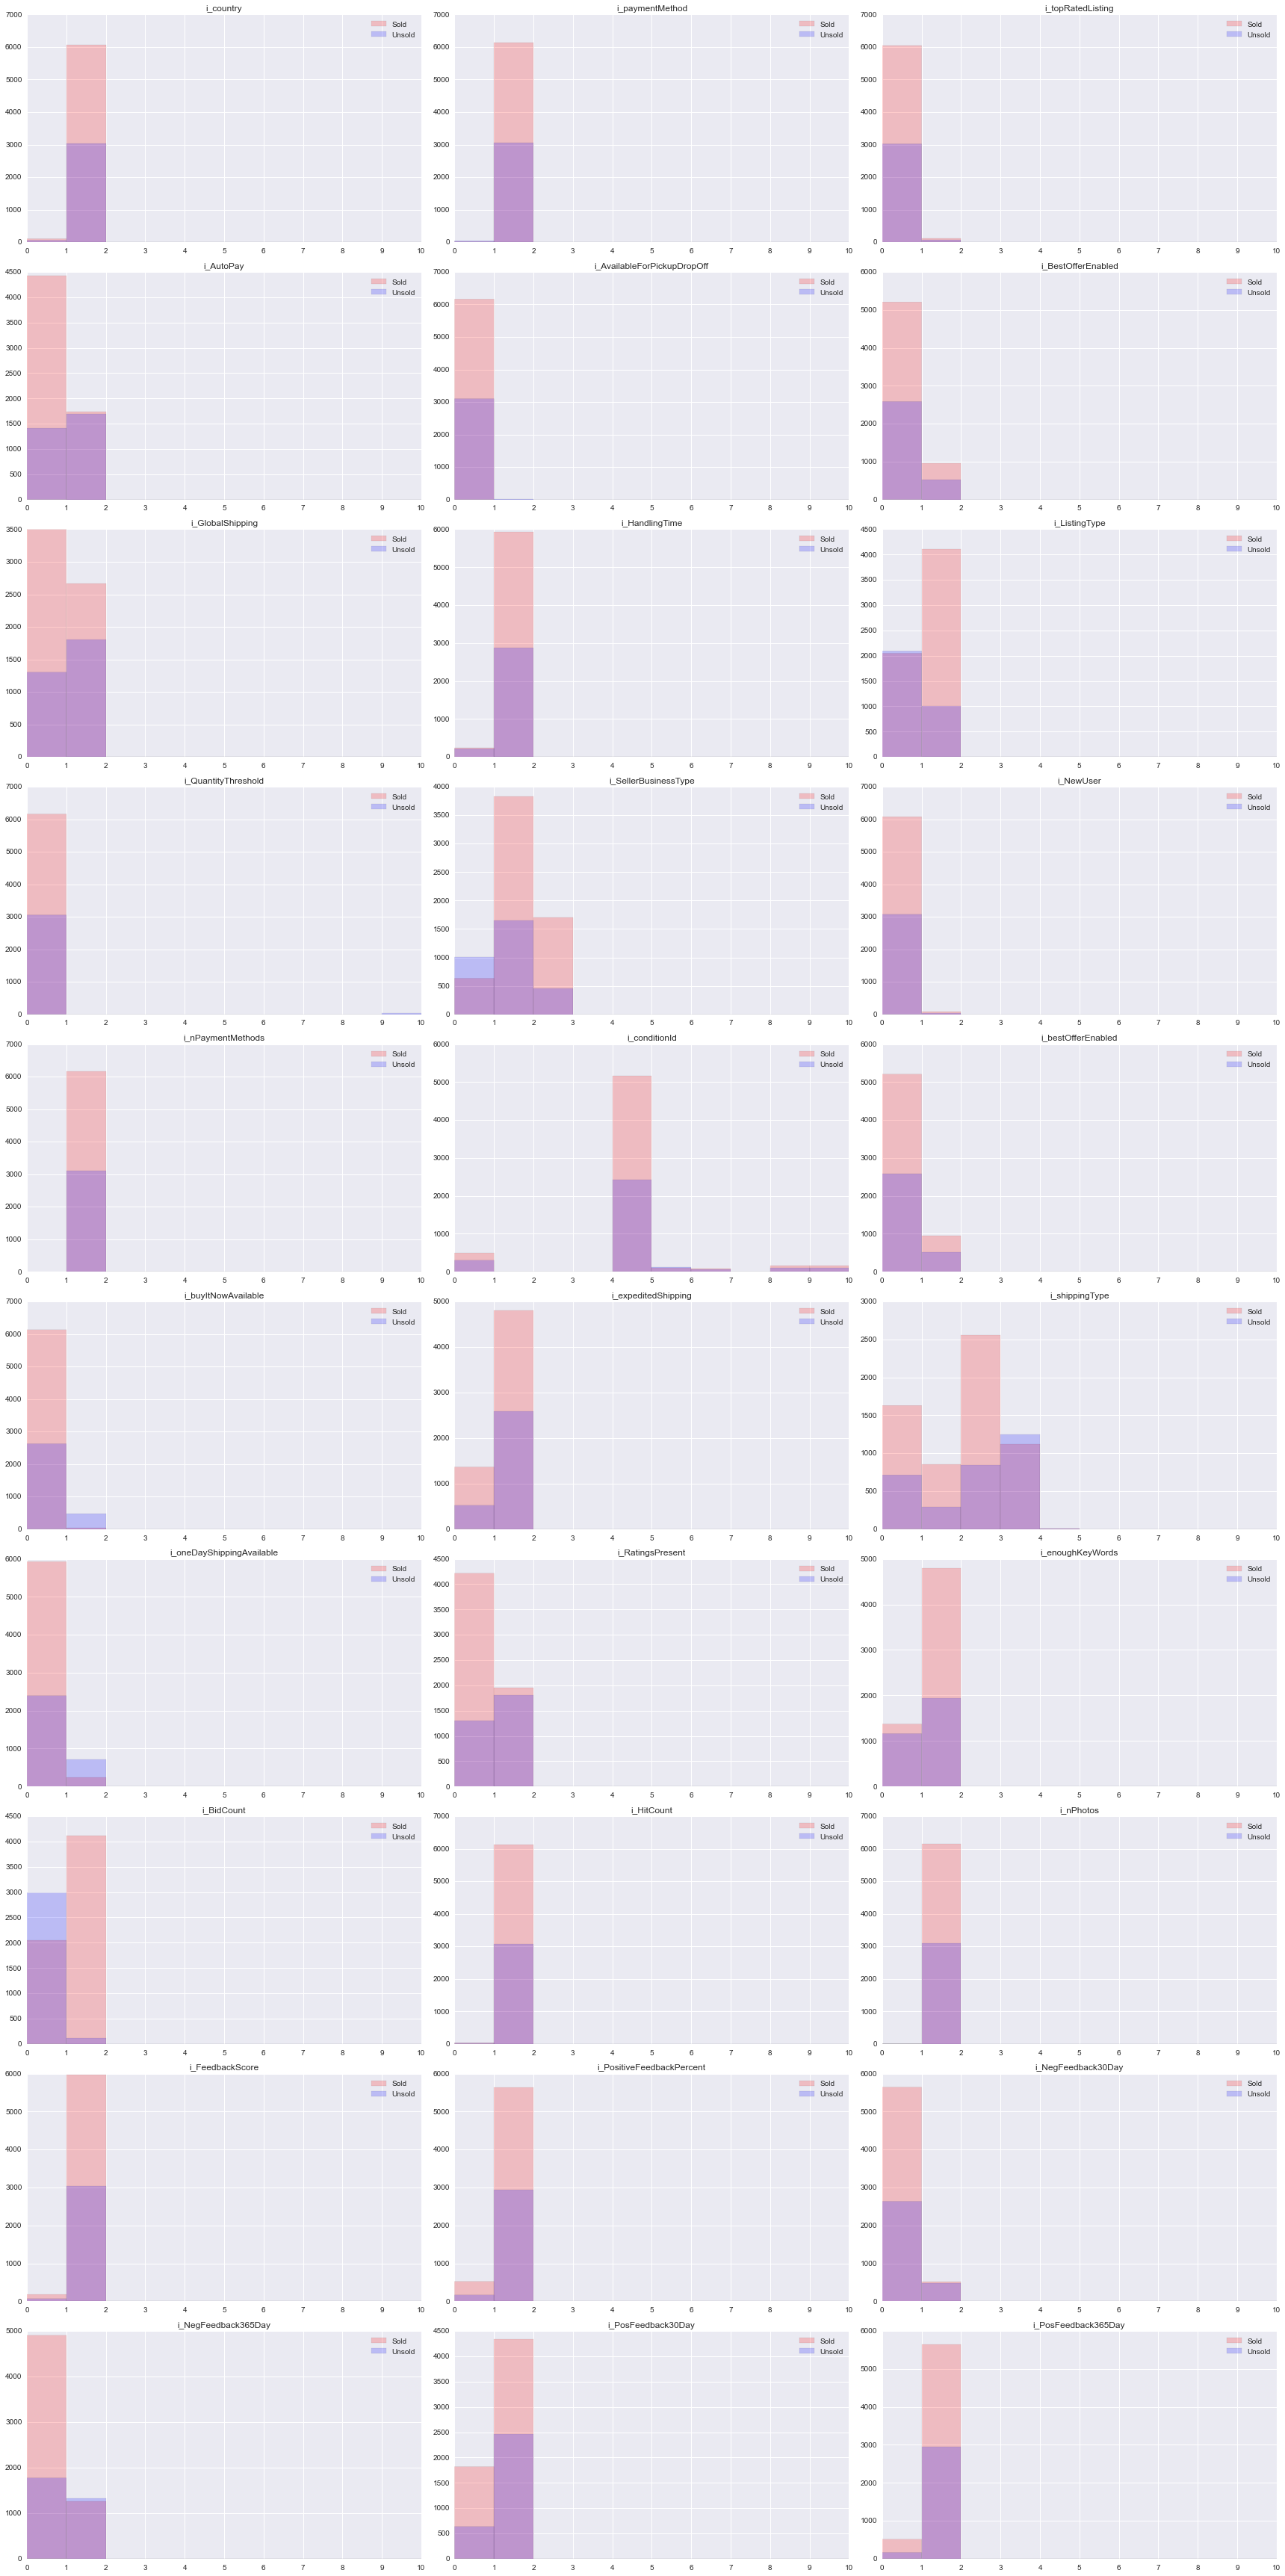

In [120]:
#setup similar layout
fig, axes = plt.subplots(nrows=10, ncols=3, figsize = (24,48),
                         tight_layout=True)

positives = dftouse[dftouse['sellingStatus'] == 1]
negatives = dftouse[dftouse['sellingStatus'] == 0]

for ax, data in zip(axes.ravel(), INDICATORS):
    ax.hist(positives[data].values, bins=10, range=[0,10], color = 'r', alpha = 0.2, label = 'Sold', rwidth=10)
    ax.hist(negatives[data].values, bins=10, range=[0,10], color = 'b', alpha = 0.2, label = 'Unsold', bottom=1)
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax.legend()
    ax.set_title(data)

We notice some obvious indications, like that with autoPay, where, while having autopay is most common (the majority of histogram values are in the 1 bin), the distribution of sold or not sold moves much more heavily toward not sold when autoPay isn't an option (bin 0). 

In [121]:
from sklearn.svm import LinearSVC

We remove the columns below from our current analysis because they contain NaN values or are not all workable indicating quantities. It would be interesting to do an analysis of how location affects sellability, but that isn't the crux of our analysis right now.

In [122]:

lcols.remove('UserID')
lcols.remove('itemId')
lcols.remove('Title')
lcols.remove('ShipToLocations')
lcols.remove('Location')
lcols.remove('postalCode')
lcols.remove('ProductID')
lcols.remove('AverageRating')
lcols.remove('BuyItNowPrice')
lcols.remove('MinimumToBid')


Now we can create a classifier using LinearSVC to implement a Linear SVM.  This will be useful later when we tackle the question of whether we should sell our iPhone on eBay or elsewhere.  We are going with a linear model because our data set is large and linear is faster than kernelized and other SVM models.

In [123]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[lcols].values
Yresp=dftouse['sellingStatus'].values

In [124]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

We then use GridSearchCV over our parameter grid of regularization coefficients (found in the Cs array) to get the best-fit classifier via 5-fold cross validation.  This will then give us the best parameter value, as well as the accuracy.

In [125]:
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(Xmatrix_train, Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'C': 1.0} 0.804193647857 [mean: 0.71585, std: 0.04241, params: {'C': 0.001}, mean: 0.78739, std: 0.03556, params: {'C': 0.01}, mean: 0.79618, std: 0.04684, params: {'C': 0.1}, mean: 0.80419, std: 0.04622, params: {'C': 1.0}, mean: 0.79093, std: 0.05672, params: {'C': 10.0}, mean: 0.72464, std: 0.13735, params: {'C': 100.0}]


In [126]:
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
best = gs.best_estimator_
best.fit(Xmatrix_train, Yresp_train)
best.score(Xmatrix_test, Yresp_test)

BEST {'C': 1.0} 0.804193647857 [mean: 0.71585, std: 0.04241, params: {'C': 0.001}, mean: 0.78739, std: 0.03556, params: {'C': 0.01}, mean: 0.79618, std: 0.04684, params: {'C': 0.1}, mean: 0.80419, std: 0.04622, params: {'C': 1.0}, mean: 0.79093, std: 0.05672, params: {'C': 10.0}, mean: 0.72464, std: 0.13735, params: {'C': 100.0}]


0.84394102840704788

In [127]:
best

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

We'll use the cv_optimize function that we wrote in HW3 to return GridSearch's best estimator.  This function is then called in do_classify.

In [128]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5,score_func=None):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,scoring=score_func)
    gs.fit(X, y)
    best = gs.best_estimator_
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    return best

In [129]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

We'll then use this function to train our data on the Linear SVM.

In [130]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, mask=mask)

using mask
BEST {'C': 1.0} 0.805118717237 [mean: 0.71585, std: 0.04241, params: {'C': 0.001}, mean: 0.78739, std: 0.03556, params: {'C': 0.01}, mean: 0.79571, std: 0.04731, params: {'C': 0.1}, mean: 0.80512, std: 0.04463, params: {'C': 1.0}, mean: 0.80065, std: 0.04897, params: {'C': 10.0}, mean: 0.79571, std: 0.03069, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.84
Accuracy on test data:     0.85
[[ 622  294]
 [ 137 1728]]
########################################################
CPU times: user 12.5 s, sys: 129 ms, total: 12.7 s
Wall time: 12.9 s


/Users/charleszhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Next we'll save them in the dictionary reuse_split to be used at a later point.

In [131]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [132]:

##this tells us that most of our values are closer to 0 than 1, which means most were successful sales
print "whole data set", dftouse['sellingStatus'].mean()#Highly asymmetric
print "training set", dftouse['sellingStatus'][mask].mean(), "test set", dftouse['sellingStatus'][~mask].mean()

whole data set 0.665155929643
training set 0.662812210916 test set 0.670622078389


### Creating the confusion matrix

Now we actually want to work thorugh and analyze our profits and costs, which will be key to helping us make a decision about whether we should sell on eBay vs. other venues.  We can start this off by creating a confusion matrix.

In [133]:
ypred=clfsvm.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[ 622,  294],
       [ 137, 1728]])

In [134]:
print "OP=", ytest.sum(), ", ON=",ytest.shape[0] - ytest.sum()

OP= 1865 , ON= 916


In [135]:
print "PP=", ypred.sum(), ", ON=",ytest.shape[0] - ypred.sum()

PP= 2022 , ON= 759


Now we're getting into the crux of our profit & cost calculations.  We must consider 4 costs: true positive (we predict that it'll be more profitable to sell on eBay, and it is in fact true), true negative (we predict that it'll be more profitable to sell elsewhere, which is in fact true), false positive (we predict that it'll be more profitable to sell on eBay, which is false), and false negative (we predict that it'll be more profitable to sell elsewhere, when in fact that is false).  In creating these costs, we must consider types of costs.  On a physical level, listing our product can have one of a few costs, depending on what features we use - the average is approximately 4.20 USD.  We can then also consider the difference in profit we would earn from selling on other sources vs. eBay, and vice versa.  To do so we must consider whether the product is used or new.  From looking at other sources such as craiglist and more, we see that on average, used iPhone 5s's tend to sell for around 225 USD, while new ones tend to sell around 280 USD.  To calculate the actual profit we will earn, we will again consider whether the product is new or old, factoring the probability of it being one of those two conditions.

In [136]:
# taking approx. average cost of listing based on whether using images, bold, short burst shor auctions, etc
listing_fee = 4.2

## we calcluate how many of our listings are top rated listings assuming our data is an simple random sample to get
## a probability of a listing being a top rated listing
size_df = float(len(dftouse.index))
y = float(len(dftouse[dftouse['i_topRatedListing'] == True]))
prob_toprated = y/size_df

## we get 90% of the profit from the sale, and if you are a top rated listing, you get %20 percent off this 10% charge
profit_margin=.9 +(.02 * prob_toprated)

## We calculate the true positive cost using the listing fee and subtracting off the profit made. We have to 
## average over new or used to make the mean better weighted for the "value" of the iPhone. We take the used value to 
## be 70% of the new value based on the fact that Apple currently sells the new one for $500 and refurbished for $340
## BestBuy: http://www.bestbuy.com/site/apple-refurbished-iphone-5s-32gb-cell-phone-unlocked-silver/1311862035.p?id=mp1311862035&skuId=1311862035
## Apple New: http://www.apple.com/shop/buy-iphone/iphone5s/32gb-space-gray

new = float(len(dftouse[dftouse['i_conditionId'] == 0]))
prob_new = new/size_df
prob_used = 1 - prob_new
profit = ((df.FinalPrice.mean())*prob_new + (df.FinalPrice.mean())*(.7 * prob_used))*profit_margin

# diff = 250 - ((df.FinalPrice.mean())*prob_new + 200 - (df.FinalPrice.mean())*(.7 * prob_used))*profit_margin


# As of December 10, 2015, Apple offers up to $320 dollars for iphone take-ins:
# http://www.apple.com/iphone/trade-in/?cid=&cp=em-P0016950-349230&sr=em
# However, other places, such as verizon and AT&T, take iphones in anwhere from 135-300 on average
# We scale the average of these for new and used eBay items, and make this part of our opportunity cost
diff = prob_new * (280 - df.FinalPrice.mean()*profit_margin) + prob_used*(225-(.7*df.FinalPrice.mean()*profit_margin))

#tpc
tpc = diff + listing_fee - profit

#tnc
tnc= -diff

# ## because we have no listing fee, our fnc is just (-tpc)
fnc = diff

# ## and our false positive cost is thus, what we would spend for listing when we shouldn't have
fpc = listing_fee + diff


We then concatenate these 4 costs into a risk matrix, as seen below:

In [137]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[ -62.44344884,   66.64344884],
       [  62.44344884, -100.64332785]])

In [138]:
u = - risk_matrix

## to avoice writing -0
#u[0][0] = 0.
#u[0][1] = 0.
u

array([[  62.44344884,  -66.64344884],
       [ -62.44344884,  100.64332785]])

The following function is useful for calculating average profit from a matrix.

In [139]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

We then consider our baseline cases for the classifiers.  The first is the case where we don't sell anything on eBay, as seen below:

In [140]:
#baseline classifier #1: don't sell anything
testsize = dftouse[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(ytest, ypred_dste)
dsteval=average_profit_pp(ytest, ypred_dste, u)
dsteval

[[ 916    0]
 [1865    0]]


-21.308462046665902

Next is the case where we sell everything on eBay, as seen below:

In [141]:
#baseline classifier #2: sell everything
testsize = dftouse[~mask].shape[0]
ypred_ste = np.ones(testsize, dtype="int")
print confusion_matrix(ytest, ypred_ste)
steval=average_profit_pp(ytest, ypred_ste, u)
steval

[[   0  916]
 [   0 1865]]


45.54275702722353

In [142]:
#calculating profit from SVM classifer using baselines
testsize = dftouse[~mask].shape[0]
ypred_svm=clfsvm.predict(Xtest)
print confusion_matrix(ytest, ypred_svm)
svmval=average_profit_pp(ytest, ypred_svm, u)
svmval

[[ 622  294]
 [ 137 1728]]


66.380283799622006


Next we'll make another classifier, this time for logistic regression.  We then calculate the profit using this new classifier.

In [143]:
#logistic regression with Lasso based feature selection
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1")
cvals = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clf, cvals, dftouse,lcols, 'sellingStatus',1, mask=mask, reuse_split=reuse_split)

using mask
using reuse split
BEST {'C': 0.1} 0.813444341659 [mean: 0.63722, std: 0.01896, params: {'C': 0.001}, mean: 0.78831, std: 0.05466, params: {'C': 0.01}, mean: 0.81344, std: 0.03329, params: {'C': 0.1}, mean: 0.80789, std: 0.03589, params: {'C': 1.0}, mean: 0.80681, std: 0.03840, params: {'C': 10.0}, mean: 0.80666, std: 0.03855, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.86
[[ 674  242]
 [ 158 1707]]
########################################################


/Users/charleszhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [144]:
#calculating profit
testsize = dftouse[~mask].shape[0]
ypred_lreg=clflog.predict(Xtest)
print confusion_matrix(ytest, ypred_lreg)
lregval=average_profit_pp(ytest, ypred_lreg, u)
lregval

[[ 674  242]
 [ 158 1707]]


67.562483141291992

##Creating ROC & Profit Curves

ROC curves are very useful for comparing the merits of different classifiers through visualization.  Making them essentially requires calculating the true positive rate (true positive / observed positive) and plotting it against the false positive rate (false positive / observed positive).

In [145]:
#Part 3
#function to make roc curves
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

As a test, we plot the logistic lasso ROC curve.

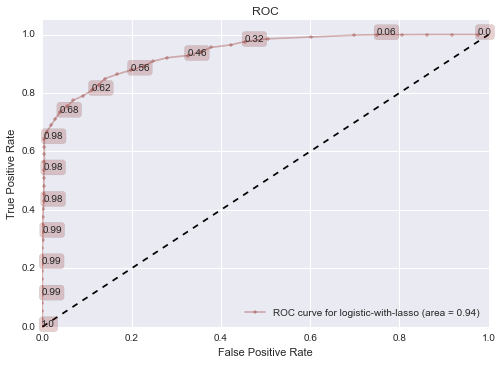

In [146]:
#logistic lasso ROC curve
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)

Looks reasonable enough.  Now let's try plotting logistic lasso against the all-features SVM.

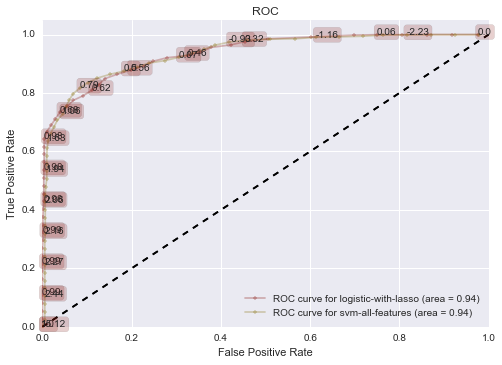

In [147]:
#logistic lasso vs. all features SVM
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)

We can see the logistic lasso ROC curve slightly outperforms the Linear SVM.

Next, let's compare the two by looking at tangent lines.  To make a tangent line, we first need to calculate the slope.

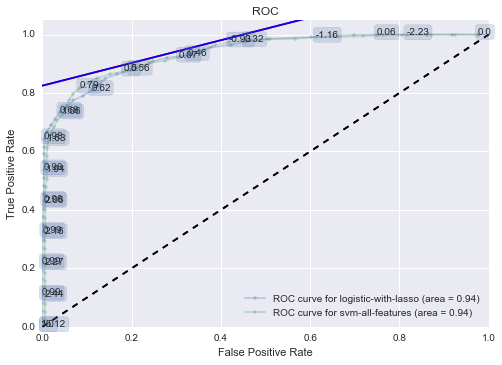

In [149]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])
slope = rat(risk_matrix)*(np.mean(ytest==0)/np.mean(ytest==1))

z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

#from IPython.html.widgets import interact, fixed
#interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.005))

make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
#.82 corresponds to the intercept predicted by calling the interact function
plt.plot(z1, slope*z1+0.825,'r')
plt.plot(z1, slope*z1+0.825,'b')

###Plotting Profit Curves
These ROC curves are interesting and all, but let's try to work with something we can more easily interpret: profit curves!  Before we can plot those, we must build up by writing multiple functions.  First we want to create a function that, given the TPR and FPR of a sample, calculates the percent of positive in a sample.  Next we want to calculate the average profit given the TPR and FPR, as well as the utility matrix.  We will then make a larger function for plotting the actual profit curves, building on the two functions we just made.

In [150]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

In [151]:
def av_profit(tpr,fpr,util,priorp,priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit
# -tnc, -fpc, -fnc, -tpc

In [152]:
def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

We now plot the profit curves for the logistic lasso & linear SVM classifiers.

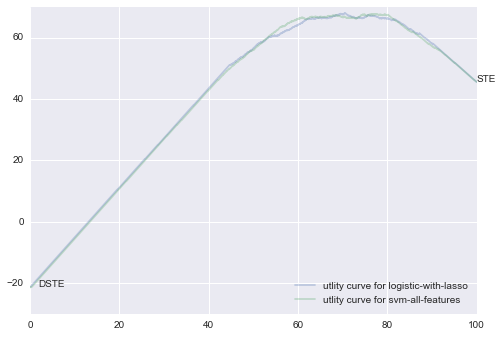

In [153]:
ax=make_profit("logistic-with-lasso", clflog, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=True)
make_profit("svm-all-features",clfsvm, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=False)
ax.annotate("STE",xy=(100,steval))
ax.annotate("DSTE",xy=(2,dsteval))
plt.legend(loc=4)

###Data Balancing and Feature Selection
As we can see above, our linear SVM slightly underperformed the logistic lasso regression.  We'll now try to improve the performance by selecting specific features that are most impactful.  We'll first experiment with this by comparing the relative coefficients assigned to each feature by the logistic lasso classifier.

In [154]:
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

In [155]:
lasso_importances=nonzero_lasso(clflog)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
i_BidCount,7.154853,7.154853
i_buyItNowAvailable,4.706921,-4.706921
i_ListingType,3.195486,-3.195486
i_oneDayShippingAvailable,0.575391,-0.575391
i_BestOfferEnabled,0.417362,0.417362
i_topRatedListing,0.416461,0.416461
auctionLength,0.386448,-0.386448
i_enoughKeyWords,0.300860,0.300860
FinalPrice,0.252392,-0.252392


Next we'll do a similar test, but this time we'll compare the correlation coefficients between each feature and the sellingstatus.

In [156]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=dftouse[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['sellingStatus'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
i_BidCount,0.594696,0.594696
BidCount,0.345853,0.345853
i_ListingType,0.315303,0.315303
i_buyItNowAvailable,0.305437,-0.305437
i_oneDayShippingAvailable,0.283118,-0.283118
i_SellerBusinessType,0.261116,0.261116
i_AutoPay,0.240621,-0.240621
i_RatingsPresent,0.239059,-0.239059
i_NegFeedback365Day,0.217856,-0.217856


As we can see above, there's quite some intersection between the two methods, as evidenced by the fact that many of the same features appear at the top of both dataframes.

Next we'll make a pipeline SVM, win which we do feature selection for our SVM, using correlation with sellingStatus.  First we make a Pearson scorer that returns the absolute correlation of the pearson coefficient.

In [157]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [158]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

Now let's run the Pipeline SVM.  First we use SelectKBest to find the 25 most correlated/anti-correlated features.  We then create a pipeline, which uses the selected features to create a new estimator.

In [159]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

Now we run the new classifier.

In [160]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 1.0} 0.804347826087 [mean: 0.65988, std: 0.01588, params: {'svm__C': 1e-05}, mean: 0.72371, std: 0.04926, params: {'svm__C': 0.001}, mean: 0.78477, std: 0.04599, params: {'svm__C': 0.01}, mean: 0.79448, std: 0.05341, params: {'svm__C': 0.1}, mean: 0.80435, std: 0.04787, params: {'svm__C': 1.0}, mean: 0.80173, std: 0.04760, params: {'svm__C': 10.0}, mean: 0.72957, std: 0.08457, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.84
Accuracy on test data:     0.84
[[ 603  313]
 [ 131 1734]]
########################################################


Let's access the selected features to see what had the greatest impact.

In [161]:
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array(['i_AutoPay', 'BidCount', 'i_GlobalShipping', 'HandlingTime',
       'i_ListingType', 'i_QuantityThreshold', 'FeedbackScore',
       'i_SellerBusinessType', 'nPaymentMethods', 'nShippingCountries',
       'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType',
       'i_oneDayShippingAvailable', 'i_RatingsPresent',
       'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day',
       'auctionLength', 'i_enoughKeyWords', 'i_HandlingTime', 'i_BidCount',
       'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day'], 
      dtype='|S27')

Now let's plot the new ROC curve using this new SVM.

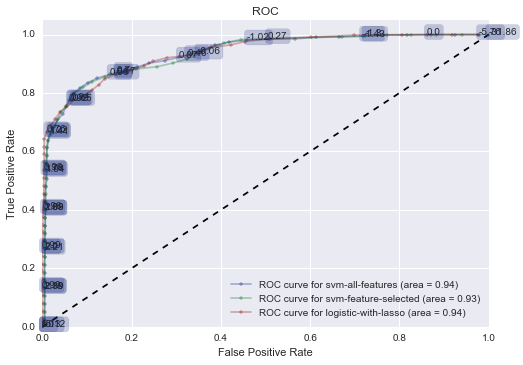

In [162]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);

The new SVM performed slightly better than our first one, but still not as good as the logistic lasso.  To fix this, let's try balancing the data.

In [163]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg


4299 2187


In [164]:
ineg = np.random.choice(jtrain[ytrain==1], n_neg, replace=False)


In [165]:
alli=np.concatenate((jtrain[ytrain==0], ineg))
alli.shape

(4374,)

In [166]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((4374, 45), (4374,))

In [167]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

In [168]:
clfsvm_b, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_new)

using reuse split
BEST {'C': 0.01} 0.810928212163 [mean: 0.76269, std: 0.05779, params: {'C': 0.001}, mean: 0.81093, std: 0.01814, params: {'C': 0.01}, mean: 0.80818, std: 0.02119, params: {'C': 0.1}, mean: 0.71696, std: 0.12852, params: {'C': 1.0}, mean: 0.71719, std: 0.12641, params: {'C': 10.0}, mean: 0.72062, std: 0.10849, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.81
Accuracy on test data:     0.77
[[ 886   30]
 [ 614 1251]]
########################################################


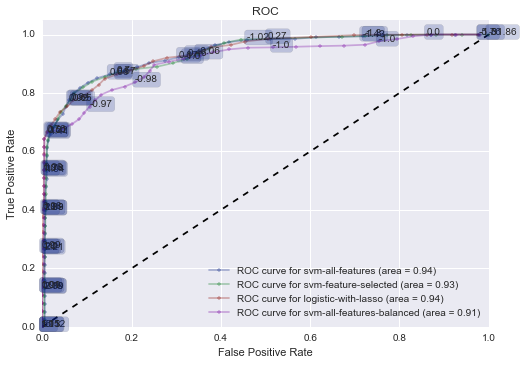

In [169]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

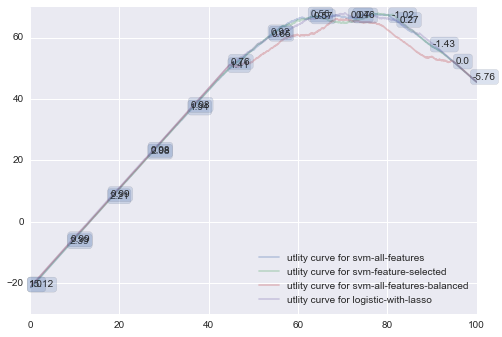

In [170]:
ax = make_profit("svm-all-features",clfsvm, ytest, Xtest, u, None, labe=250, threshold=True, proba=False)
make_profit("svm-feature-selected",pipelinearsvm, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=250, threshold=True);
plt.legend(loc=4)

In [171]:
from sklearn.svm import SVC

In [172]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In [173]:
jtrain_new=np.arange(0, ytrain_new.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain_new==1], 300, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain_new==0], 300, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain_new[subsampled_i]
ytrain_new2=ytrain_new[subsampled_i]

In [174]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

In [175]:
%%time
#your code here
params = {"svm2__C": [1e8], "svm2__gamma":[1e-9,1e-7,1e-5],"svm2__kernel":["rbf"]}
clfsvm_subsampled, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm2, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'} 0.83 [mean: 0.64333, std: 0.02068, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.81833, std: 0.02603, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.83000, std: 0.04460, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.83
[[ 749  167]
 [ 305 1560]]
########################################################
CPU times: user 2.83 s, sys: 32.4 ms, total: 2.87 s
Wall time: 2.96 s


In [176]:
%%time
#your code here
selectorsvm3 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm3 = Pipeline([('select3', selectorsvm3), ('svm2', SVC(C=1e8,gamma=1e-9,kernel="rbf"))])
clfsvm_k, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm3, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'} 0.83 [mean: 0.64333, std: 0.02068, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.81833, std: 0.02603, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.83000, std: 0.04460, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.83
[[ 749  167]
 [ 305 1560]]
########################################################
CPU times: user 2.7 s, sys: 25.2 ms, total: 2.72 s
Wall time: 2.75 s


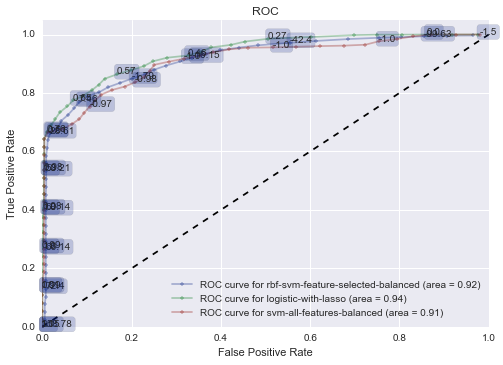

In [177]:
#Part 5
with sns.color_palette("dark"):
    ax=make_roc("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

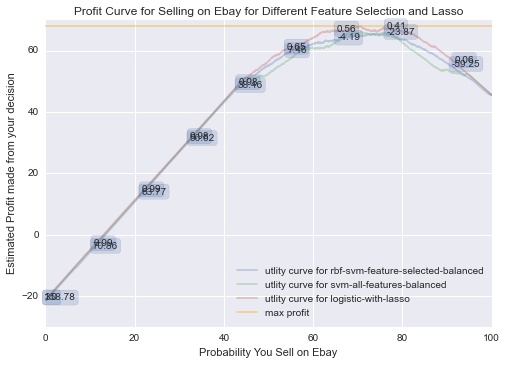

In [178]:
ax = make_profit("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, u, None, labe=300, threshold=True, proba=False)

make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=300, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=300, threshold=True);
plt.axhline(68, color='orange', alpha=.4, label='max profit')
plt.xlabel("Probability You Sell on Ebay")
plt.ylabel("Estimated Profit made from your decision")
plt.title("Profit Curve for Selling on Ebay for Different Feature Selection and Lasso")
plt.legend(loc=4)

## What this tells us

The x-axis on this plot tells us a probability of whether or not you sell on eBay. Our